# Data-driven scouting in *Football Manager 2023*
##### Using Principal Component Analysis and K-means clustering to find the 'next Virgil van Dijk' for a team promoted to Ligue 1

### By Nathan Chbarbi

This project involves using FM23 in-game data to find a Ball-Playing Defender of the mold of Virgil van Dijk for my FC Girondins de Bordeaux save in *Football Manager 2023* after getting promoted from Ligue 2. This notebook analyzes a dataset acquired through the game *Football Manager 2023* in the Players in Range tab, (Scouting -> Players -> Players in Range) which shows all available players you can sign depending on the club's scouting package. Solely for this project, I chose the largest possible scouting package, covering all players in the world to give me the most data. This gave me 113,758 possible players to choose from, and we were going to narrow down the dataset to a select few that would be suitable signings for a team recently promoted to Ligue 1. 


<center>
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/1/11/FC_Girondins_de_Bordeaux_logo.svg/1200px-FC_Girondins_de_Bordeaux_logo.svg.png" width="50%" height="50%">
</center>


**Credit** to Edd Webster (*https://github.com/eddwebster*) who inspired me to start this project after looking at his "PCA and K-Means Clustering of 'Piqué-like' Defenders". For more information about Edd Webster, see his following links:

*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Contents</a>
1.    [Setup](#section1)<br>
2.    [Importing data](#section2)<br>
3.    [Data cleaning](#section3)<br>
4.    [Machine Learning](#section4)<br>
5.    [Data Visualization](#section5)<br>
6.    [Exploratory Data Analysis](#section6)<br>
7.    [Shortlist Deep Dive](#section7)<br>
8.    [Conclusion](#section8)<br>
9.    [Next Steps](#section9)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Setup</a>

This notebook is written on Python 3 and uses the following libraries:
* `NumPy` for mathematical functions
* `pandas` for data analysis
* `sklearn` for machine learning
* `matplotlib` and `seaborn` for data viz
* `mplsoccer` for constructing soccer-specific radar charts

### Import libraries

In [61]:
# Math
import numpy as np
import math
from scipy import stats

# Datetime
import datetime

# Data Analysis
import pandas as pd

# For reading directories
import os

# Data Viz
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# Radar plots
from PIL import Image
from mplsoccer import PyPizza, add_image, FontManager
from highlight_text import fig_text

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Other
from urllib.request import urlopen
from IPython.display import Image
from IPython.core.display import HTML 

# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Importing fonts
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

# Print Statement
print('Setup Complete')

Setup Complete


### Set up working directory

In [63]:
os.getcwd()

'/Users/nathanchbarbi/anaconda_projects/fm23_scouting'

In [64]:
os.chdir('/Users/nathanchbarbi/anaconda_projects/fm23_scouting')
os.getcwd()

'/Users/nathanchbarbi/anaconda_projects/fm23_scouting'

Great, all is set up to import data and start analysis!

___
<a id='section1'></a>

## <a id='#section1'>2. Importing data</a>

In [67]:
df_raw = pd.read_csv('bpd_2023-24.csv')
df = df_raw
df.head()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
0,Rúben Dias,Man City,Premier League,POR,D (C),-,Right,Set,NaN,27.0,"4,222",76.12,5.29,94%,0.06,0.02,0.13,82%,75%,0.96,0.19,6.4,0.58,3.26,0.51,0.66,1.41,3.03,62,319.0mi,- - -,"$325,000 p/w",6/30/27,Not for Sale
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32.0,"4,271",72.93,6.11,93%,0.06,0.03,0.19,74%,78%,0.84,0.19,7,0.82,3.25,0.65,0.89,1.64,3.9,36,317.5mi,- - -,"$325,000 p/w",6/30/25,Not for Sale
2,Aymeric Laporte,Man City,Premier League,ESP,D (C),Trained in nation (0-21),Left,Set,NaN,30.0,"3,248",73.46,5.29,94%,0.05,0.03,0.17,85%,72%,1.08,0.28,6.01,0.67,2.91,0.64,1.05,1.63,3.88,16,246.6mi,- - -,"$325,000 p/w",6/30/26,Not for Sale
3,Raphaël Varane,Man Utd,Premier League,FRA,D (C),Trained in nation (15-21),Right,Set,NaN,31.0,"3,528",62.6,4.92,92%,0.05,0.03,0.13,74%,78%,1.02,0.36,8.09,0.97,2.6,0.84,1.35,1.94,3.93,20,270.3mi,- - -,"$350,000 p/w",6/30/26,Not for Sale
4,Matthijs de Ligt,Bayern München,Bundesliga,NED,"D (C), DM",-,Right,NaN,NaN,24.0,"2,270",79.33,6.22,94%,0.14,0.02,0.32,75%,84%,0.71,0.12,7.14,0.44,2.42,0.12,0.59,2.3,5.71,29,181.9mi,- - -,"$300,000 p/w",6/30/26,$86M - $108M


In [68]:
df.tail()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
20220,Lee Sung-Bin,NaN,-,KOR,D (C),-,Unknown,FrA,NaN,25.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,- - -,-,-,$0
20221,Senai Berhane,FC Björnligan,Swedish Lower Division,ERI,D (C),-,Unknown,Ama,NaN,35.0,900,14.6,0,73%,0.08,0,-,100%,-,1.4,0,-,0,-,-,0,0,0,14,0.0mi,- - -,NaN,-,Unknown
20222,Magni Mohr,FC Suðuroy,2. deild,FRO,D (C),-,Unknown,Ama,NaN,50.0,"1,080",12.42,0,62%,0.01,0,-,95%,-,1.5,0,-,0,-,-,0,0,0,23,0.0mi,- - -,NaN,-,Unknown
20223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20224,https://www.sigames.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Removing last 2 rows
The last two rows contain null values and the credits to Sports Interactive. We will remove these last 2 rows for the sake of analysis

In [70]:
df = df.iloc[:-2]
df.tail()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
20218,Mohamed Rawme Mohideen,Colombo,Dialog Champions League,SRI,D (C),-,Unknown,NaN,NaN,44.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,- - -,$6 p/w,12/31/23,Unknown
20219,Therry Phobère,CA Plan de Cuques,Ligues régionales,FRA,D (C),Trained in nation (0-21),Unknown,Yth,NaN,15.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,- - -,NaN,6/30/27,Unknown
20220,Lee Sung-Bin,NaN,-,KOR,D (C),-,Unknown,FrA,NaN,25.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,- - -,-,-,$0
20221,Senai Berhane,FC Björnligan,Swedish Lower Division,ERI,D (C),-,Unknown,Ama,NaN,35.0,900,14.6,0,73%,0.08,0,-,100%,-,1.4,0,-,0,-,-,0,0,0,14,0.0mi,- - -,NaN,-,Unknown
20222,Magni Mohr,FC Suðuroy,2. deild,FRO,D (C),-,Unknown,Ama,NaN,50.0,"1,080",12.42,0,62%,0.01,0,-,95%,-,1.5,0,-,0,-,-,0,0,0,23,0.0mi,- - -,NaN,-,Unknown


___
<a id='section1'></a>

## <a id='#section1'>3. Data cleaning</a>

We will convert display the data types of each column to see which need to be converted to numerical types ahead of the machine learning and analysis.

In [72]:
df.dtypes

Name                  object
Club                  object
Division              object
Nat                   object
Position              object
Home Grown Status     object
Preferred Foot        object
Inf                   object
WR                   float64
Age                  float64
Mins                  object
Ps C/90               object
Pr passes/90          object
Pas %                 object
NP-xG/90              object
xA/90                 object
Drb/90                object
Tck R                 object
Hdr %                 object
Tck/90                object
K Tck/90              object
Hdrs W/90             object
K Hdrs/90             object
Int/90                object
Blk/90                object
Clr/90                object
Pres C/90             object
Pres A/90             object
Fls                   object
Distance              object
Rec                   object
Salary                object
Expires               object
Transfer Value        object
dtype: object

<a id='section3.1'></a>

### <a id='#section3.1'> 3.1 Data dictionary </a>

The raw dataset has thirty-three (columns) with the following definitions and data types:

| No.     | Variable     | Data Type    | Description    |
|------|------|-----|-----|
| 1    | `Name`    | object    | **Player's name**|
| 2    | `Club`    | object    | **Name of club**|
| 3    | `Division`    | object    | **League of player's club**|
| 3    | `Nat`    | object    | **Nationality**|
| 4    | `Position`    | object    | **Player's positions**|
| 5    | `Home Grown Status`    | object    | **Player's Home Grown Status** (relating to France as nation or Bordeaux as club)|
| 6    | `Preferred Foot`    | object    | **Dominant foot** (or feet)|
| 7    | `Inf`    | object    | **Player Status** (as in if player is injured or wanted by a club, relates to the Football Manager)|
| 8    | `WR`    | float64    | **World Reputation of player** (shown out of 5 stars, but did not format in a .csv file)|
| 9    | `Age`    | float64    | **Age**|
| 10    | `Mins`    | object    | **Minutes played**|
| 11    | `Ps C/90`    | float64    | **Passes completed per 90 minutes**|
| 12    | `Pr passes/90`    | float64    | **Progressive passes per 90 minutes**|
| 13    | `Pas %`    | object    | **Pass completed rate**|
| 14    | `NP-xG/90`    | float64    | **Non-penalty expected goals per 90 minutes**|
| 15    | `xA/90`    | float64    | **Expected assists per 90 minutes**|
| 16    | `Drb/90`    | object    | **Dribbles made per 90 minutes**|
| 17    | `Tck R`    | object    | **Tackle Success Ratio**|
| 18    | `Hdr %`    | object    | **Percentage of Headers won**|
| 19    | `Tck/90`    | float64    | **Tackles made per 90 minutes**|
| 20    | `K Tck/90`    | float64    | **Key Tackles per 90 minutes**|
| 21    | `Hdrs W/90`    | float64    | **Headers Won per 90 minutes**|
| 22    | `K Hdrs/90`    | float64    | **Key Headers per 90 minutes**|
| 23    | `Int/90`    | float64    | **Interceptions per 90 minutes**|
| 24    | `Blk/90`    | float64    | **Blocks per 90 minutes**|
| 25    | `Clr/90`    | float64    | **Clearances per 90 minutes**|
| 26    | `Pres C/90`    | float64    | **Pressures completed per 90 minutes**|
| 27    | `Pres A/90`    | float64    | **Pressure attempted per 90 minutes**|
| 28    | `Fls`    | float64    | **Fouls made**|
| 29    | `Distance`    | object    | **Distance covered**|
| 30    | `Rec`    | object    | **Scout's recommendation** (an in-game grade of a player ranging from A+ to F that does not format into a .csv file)|
| 31    | `Salary`    | object    | **Weekly salary (USD)**|
| 32    | `Expires`    | object    | **Contract expiration date**|
| 34    | `Transfer Value`    | object    | **Estimate of player's price**|

<a id='section3.2'></a>

### <a id='#section3.2'> 3.2 Variables of Interest </a>

Out of these variables, the ones that are of most importance are the outputs of one's performance. Thus we are looking for:

* `Ps C/90`
* `Pr passes/90`
* `Pas %`
* `NP-xG/90`
* `xA/90`
* `Drb/90`
* `Tck R`
* `Hdr %`
* `Tck/90`
* `K Tck/90`
* `Hdrs W/90`
* `K Hdrs/90`
* `Int/90`
* `Blk/90`
* `Clr/90`
* `Pres C/90`
* `Pres A/90`
* `Fls`
* `Distance`

All of the data must be normalized to some extent, whether it is per 90 minutes or as a percentage. The variables `Fls` and `Distance` need normalizing, so that we get an idea of how well a player may perform in a certain metric given they play 90 minutes. While it is important to play as many minutes as possible, we do not include minutes played since it is not reflective of what a player does on the pitch. Instead, we will filter the data later so that only players who have played more than 2,000 minutes show up. 

<a id='section3.3'></a>

### <a id='#section3.3'> 3.3 Converting data to numerical type </a>

For this analysis, we want our data to be converted to a numerical type so we will be able to run Principal Component Analysis followed by K-means clustering. Many of the numerical variables are strings (objects), so we want to change them to integers or floats.

These include: 
- `Mins`
- `Ps C/90`
- `Pr passes/90`
- `Pas %`
- `NP-xG/90`
- `xA/90`
- `Drb/90`
- `Tck R`
- `Hdr %`
- `Tck/90`
- `K Tck/90`
- `Hdrs W/90`
- `K Hdrs/90`
- `Int/90`
- `Blk/90`
- `Clr/90`
- `Pres C/90`
- `Pres A/90`
- `Fls`
- `Distance`
- `Salary`
- `Expires` (to change to datetime)

While we had not mentioned `Mins`, `Salary`, `Expires` in the variables of interest, they will be used to filter results later down in the notebook. Most of these variables are displayed as strings because *Football Manager* displays numbers in the thousands are with a comma, and null values are sometimes represented by a dash '-'.  :/

In [76]:
# Creating list of variabes to change
to_modify = ['Mins',
             'Ps C/90',
             'Pr passes/90',
             'Pas %',
             'NP-xG/90',
             'xA/90',
             'Drb/90',
             'Tck R',
             'Hdr %',
             'Tck/90',
             'K Tck/90',
             'Hdrs W/90',
             'K Hdrs/90',
             'Int/90',
             'Blk/90',
             'Clr/90',
             'Pres C/90',
             'Pres A/90',
             'Fls',
             'Distance',
             'Salary']

# Replacing null or '-' values with 0, and removing commas, %, $, mi
for column in to_modify:
    df[column] = df[column].replace('-','0', regex=True).replace(
        '%','', regex=True).replace(',','', regex=True).replace('\\$','', regex=True).replace(
        ' p/w','', regex=True).replace('mi', '', regex=True).fillna(0)

We have removed the commas, the percentages, the dollar signs, the 'per week' in the salary, the miles in the distance, and also replaced the dashes with a zero. 

In [78]:
df.head()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
0,Rúben Dias,Man City,Premier League,POR,D (C),-,Right,Set,NaN,27.0,4222,76.12,5.29,94,0.06,0.02,0.13,82,75,0.96,0.19,6.4,0.58,3.26,0.51,0.66,1.41,3.03,62,319.0,- - -,325000,6/30/27,Not for Sale
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32.0,4271,72.93,6.11,93,0.06,0.03,0.19,74,78,0.84,0.19,7,0.82,3.25,0.65,0.89,1.64,3.9,36,317.5,- - -,325000,6/30/25,Not for Sale
2,Aymeric Laporte,Man City,Premier League,ESP,D (C),Trained in nation (0-21),Left,Set,NaN,30.0,3248,73.46,5.29,94,0.05,0.03,0.17,85,72,1.08,0.28,6.01,0.67,2.91,0.64,1.05,1.63,3.88,16,246.6,- - -,325000,6/30/26,Not for Sale
3,Raphaël Varane,Man Utd,Premier League,FRA,D (C),Trained in nation (15-21),Right,Set,NaN,31.0,3528,62.6,4.92,92,0.05,0.03,0.13,74,78,1.02,0.36,8.09,0.97,2.6,0.84,1.35,1.94,3.93,20,270.3,- - -,350000,6/30/26,Not for Sale
4,Matthijs de Ligt,Bayern München,Bundesliga,NED,"D (C), DM",-,Right,NaN,NaN,24.0,2270,79.33,6.22,94,0.14,0.02,0.32,75,84,0.71,0.12,7.14,0.44,2.42,0.12,0.59,2.3,5.71,29,181.9,- - -,300000,6/30/26,$86M - $108M


In [79]:
df.tail()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
20218,Mohamed Rawme Mohideen,Colombo,Dialog Champions League,SRI,D (C),-,Unknown,NaN,NaN,44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,- - -,6,12/31/23,Unknown
20219,Therry Phobère,CA Plan de Cuques,Ligues régionales,FRA,D (C),Trained in nation (0-21),Unknown,Yth,NaN,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,- - -,0,6/30/27,Unknown
20220,Lee Sung-Bin,NaN,-,KOR,D (C),-,Unknown,FrA,NaN,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,- - -,0,-,$0
20221,Senai Berhane,FC Björnligan,Swedish Lower Division,ERI,D (C),-,Unknown,Ama,NaN,35.0,900,14.6,0,73,0.08,0,0,100,0,1.4,0,0,0,0,0,0,0,0,14,0.0,- - -,0,-,Unknown
20222,Magni Mohr,FC Suðuroy,2. deild,FRO,D (C),-,Unknown,Ama,NaN,50.0,1080,12.42,0,62,0.01,0,0,95,0,1.5,0,0,0,0,0,0,0,0,23,0.0,- - -,0,-,Unknown


Now that the non-numerical characters have been removed or replaced, we can change the variables to a numerical type in order to follow with principal component analysis. We are also making the contract expiration date into a datetime object because it will be important later.

In [81]:
# Changing data types to numerical types

df = df.apply(pd.to_numeric, errors='coerce', downcast = 'integer').fillna(df)

df['Expires'] = df['Expires'].replace('-',np.nan)
df['Expires'] = pd.to_datetime(df['Expires'])
df.head()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value
0,Rúben Dias,Man City,Premier League,POR,D (C),-,Right,Set,NaN,27,4222,76.12,5.29,94,0.06,0.02,0.13,82,75,0.96,0.19,6.40,0.58,3.26,0.51,0.66,1.41,3.03,62,319.0,- - -,325000,2027-06-30,Not for Sale
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32,4271,72.93,6.11,93,0.06,0.03,0.19,74,78,0.84,0.19,7.00,0.82,3.25,0.65,0.89,1.64,3.90,36,317.5,- - -,325000,2025-06-30,Not for Sale
2,Aymeric Laporte,Man City,Premier League,ESP,D (C),Trained in nation (0-21),Left,Set,NaN,30,3248,73.46,5.29,94,0.05,0.03,0.17,85,72,1.08,0.28,6.01,0.67,2.91,0.64,1.05,1.63,3.88,16,246.6,- - -,325000,2026-06-30,Not for Sale
3,Raphaël Varane,Man Utd,Premier League,FRA,D (C),Trained in nation (15-21),Right,Set,NaN,31,3528,62.60,4.92,92,0.05,0.03,0.13,74,78,1.02,0.36,8.09,0.97,2.60,0.84,1.35,1.94,3.93,20,270.3,- - -,350000,2026-06-30,Not for Sale
4,Matthijs de Ligt,Bayern München,Bundesliga,NED,"D (C), DM",-,Right,NaN,NaN,24,2270,79.33,6.22,94,0.14,0.02,0.32,75,84,0.71,0.12,7.14,0.44,2.42,0.12,0.59,2.30,5.71,29,181.9,- - -,300000,2026-06-30,$86M - $108M


In [82]:
df.dtypes

Name                         object
Club                         object
Division                     object
Nat                          object
Position                     object
Home Grown Status            object
Preferred Foot               object
Inf                          object
WR                           object
Age                            int8
Mins                          int16
Ps C/90                     float64
Pr passes/90                float64
Pas %                          int8
NP-xG/90                    float64
xA/90                       float64
Drb/90                      float64
Tck R                          int8
Hdr %                          int8
Tck/90                      float64
K Tck/90                    float64
Hdrs W/90                   float64
K Hdrs/90                   float64
Int/90                      float64
Blk/90                      float64
Clr/90                      float64
Pres C/90                   float64
Pres A/90                   

The initial cleaning worked but we must add more metrics, such as distance covered per 90 minutes and fouls made per 90 minutes as these are key metrics for centerbacks.

In [84]:
# Adding metrics

# 90s
df['90s'] = df['Mins'] / 90

# Distance covered / 90
df['Distance/90'] = df['Distance'] / df['90s']

# Fouls / 90
df['Fls/90'] = df['Fls'] / df['90s']

df.columns
df.head()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90
0,Rúben Dias,Man City,Premier League,POR,D (C),-,Right,Set,NaN,27,4222,76.12,5.29,94,0.06,0.02,0.13,82,75,0.96,0.19,6.40,0.58,3.26,0.51,0.66,1.41,3.03,62,319.0,- - -,325000,2027-06-30,Not for Sale,46.911111,6.800095,1.321649
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32,4271,72.93,6.11,93,0.06,0.03,0.19,74,78,0.84,0.19,7.00,0.82,3.25,0.65,0.89,1.64,3.90,36,317.5,- - -,325000,2025-06-30,Not for Sale,47.455556,6.690471,0.758605
2,Aymeric Laporte,Man City,Premier League,ESP,D (C),Trained in nation (0-21),Left,Set,NaN,30,3248,73.46,5.29,94,0.05,0.03,0.17,85,72,1.08,0.28,6.01,0.67,2.91,0.64,1.05,1.63,3.88,16,246.6,- - -,325000,2026-06-30,Not for Sale,36.088889,6.833128,0.443350
3,Raphaël Varane,Man Utd,Premier League,FRA,D (C),Trained in nation (15-21),Right,Set,NaN,31,3528,62.60,4.92,92,0.05,0.03,0.13,74,78,1.02,0.36,8.09,0.97,2.60,0.84,1.35,1.94,3.93,20,270.3,- - -,350000,2026-06-30,Not for Sale,39.200000,6.895408,0.510204
4,Matthijs de Ligt,Bayern München,Bundesliga,NED,"D (C), DM",-,Right,NaN,NaN,24,2270,79.33,6.22,94,0.14,0.02,0.32,75,84,0.71,0.12,7.14,0.44,2.42,0.12,0.59,2.30,5.71,29,181.9,- - -,300000,2026-06-30,$86M - $108M,25.222222,7.211894,1.149780


<a id='section3.4'></a>
### <a id='#section3.4'> 3.4 Initial filtering of data </a>

To filter out players that a newly-promoted Ligue 1 club would never even think about signing, we need to tighten the criteria for players that show up in the dataset before analyzing. However, which sort of players would we not think about signing?

1. Amateur players. A smart Ligue 1 side would not scout amateur players, so we need to filter players who earn a salary (Salary != 0)
2. Players who miss a lot of time in the season or do not start for their clubs. This is a data-driven approach, and while it could be useful to take a look at players who are putting out great numbers with limited minutes, we have to make sure they are capable of keeping the standard over 2000 minutes in a season to minimize the risk of signing a potential flop. (Mins >= 2000)
3. Non-athletic players. Ligue 1 is one of the most physical leagues in the world, which require great athletism. We will remove players who do not cover at least 5 miles of distance per 90 minutes.
4. Players playing in a weak league. This dataset also contains data from centerbacks playing in Europe's top divisions and amateur divisions. While the strength of these leagues are very different, we will filter by a selection of the top 35 European leagues according to the Football Manager game save. 

In [86]:
df.shape

(20223, 37)

<a id='section3.4.1'></a>
#### <a id='#section3.4.1'> 3.4.1 Filtering out non-contracted players </a>

In [88]:
df = df[df['Salary'] != 0]
df.shape
#df.tail()

(18417, 37)

<a id='section3.4.2'></a>
#### <a id='#section3.4.2'> 3.4.2 Filtering for players who played 2,000 minutes </a>

In [90]:
df = df[df['Mins'] >= 2000]
df.shape
df.tail()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90
19900,Juande,Los Molinos,Spanish U19 Division 2 Group 13,ESP,D (C),-,Right,NaN,NaN,31,3870,13.58,0.00,68,0.02,0.00,0.00,99,0,1.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50,0.0,- - -,15,2023-06-30,$0,43.000000,0.000000,1.162791
20010,Geja,Boavista da Praia,Santiago (South) Premier Division,CPV,D (C),-,Unknown,NaN,NaN,36,3663,37.79,4.69,65,0.09,0.02,0.02,76,60,0.61,0.17,8.55,0.42,4.18,0.74,1.84,1.43,3.19,24,233.2,- - -,6,2023-06-30,Unknown,40.700000,5.729730,0.589681
20124,Dwayne Forbes,United FC (BAH),BFA Senior League,BAH,D (C),-,Unknown,Ret,NaN,35,2610,13.28,0.00,66,0.01,0.00,0.00,96,0,1.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,56,0.0,- - -,15,2023-06-30,Unknown,29.000000,0.000000,1.931034
20142,Sam Dowell,Renegades FC,BFA Senior League,USA,D (C),-,Unknown,Ret,NaN,35,2608,34.44,4.11,70,0.03,0.02,0.69,81,55,1.21,0.03,4.38,0.38,4.24,0.62,1.41,2.21,6.49,44,216.5,- - -,45,2023-06-30,Unknown,28.977778,7.471242,1.518405
20213,Andy Figaroa,Nacional (ARU),Aruban Division di Honor,ARU,D (C),-,Unknown,NaN,NaN,40,2718,13.15,0.00,64,0.02,0.00,0.00,100,0,1.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35,0.0,- - -,15,2023-06-30,Unknown,30.200000,0.000000,1.158940


<a id='section3.4.3'></a>
#### <a id='#section3.4.3'> 3.4.3 Filtering for players who cover 5 mi/90 </a>

In [92]:
df = df[df['Distance/90'] >= 5.0]
df.shape
df.tail()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90
19614,Derrick Brangman,Devonshire Cougars,Digicel Premier Division,BER,"D (C), DM",-,Unknown,Ret,NaN,34,2103,41.90,3.81,69,0.06,0.02,0.00,100,69,0.60,0.09,9.29,0.17,3.59,0.94,1.75,0.94,3.08,28,133.8,- - -,9,2023-06-30,Unknown,23.366667,5.726106,1.198288
19749,Tarik Jennings,North Village Rams,Digicel Premier Division,BER,D (RC),-,Unknown,NaN,NaN,20,2509,39.17,4.34,64,0.13,0.06,0.18,70,61,0.50,0.14,8.97,0.14,4.73,0.75,1.76,1.29,3.23,18,183.9,- - -,30,2024-06-30,Unknown,27.877778,6.596652,0.645676
19775,Jishua Butterfield,Devonshire Cougars,Digicel Premier Division,BER,D (C),-,Unknown,NaN,NaN,20,2519,37.84,3.72,66,0.07,0.01,0.00,100,67,0.71,0.11,9.90,0.25,4.25,0.82,1.86,1.18,2.82,16,173.4,- - -,45,2024-06-30,Unknown,27.988889,6.195316,0.571655
20010,Geja,Boavista da Praia,Santiago (South) Premier Division,CPV,D (C),-,Unknown,NaN,NaN,36,3663,37.79,4.69,65,0.09,0.02,0.02,76,60,0.61,0.17,8.55,0.42,4.18,0.74,1.84,1.43,3.19,24,233.2,- - -,6,2023-06-30,Unknown,40.700000,5.729730,0.589681
20142,Sam Dowell,Renegades FC,BFA Senior League,USA,D (C),-,Unknown,Ret,NaN,35,2608,34.44,4.11,70,0.03,0.02,0.69,81,55,1.21,0.03,4.38,0.38,4.24,0.62,1.41,2.21,6.49,44,216.5,- - -,45,2023-06-30,Unknown,28.977778,7.471242,1.518405


<a id='section3.4.4'></a>
#### <a id='#section3.4.4'> 3.4.4 Filtering for players in top 35 European leagues </a>

In [94]:
df_leagues = pd.read_csv('top_leagues.csv')

top35_leagues = df_leagues['Name'][:35].tolist()
top35_leagues

df = df[df['Division'].isin(top35_leagues)]
df.shape
#df.tail()

(1243, 37)

We have filtered down our dataset from 20,223 players to 1,243 using simple filtering methods. Now we must prepare the data for our machine learning procedures.

<a id='section3.5'></a>
### <a id='#section3.5'> 3.5 Creation of numerical dataframe </a>

All but creating a subset of the data is done, and next step is undergoing PCA and K-means clustering

In [97]:
selected_stats =['Ps C/90',
                 'Pr passes/90',
                 'Pas %',
                 'NP-xG/90',
                 'xA/90',
                 'Drb/90',
                 'Tck R',
                 'Hdr %',
                 'Tck/90',
                 'K Tck/90',
                 'Hdrs W/90',
                 'K Hdrs/90',
                 'Int/90',
                 'Blk/90',
                 'Clr/90',
                 'Pres C/90',
                 'Pres A/90',
                 'Distance/90',
                 'Fls/90'
                ]

# Numerical-only values dataframe
num_df = df[selected_stats]
num_df.head()

# Counting N/A values in dataframe
num_df.isna().sum().sum()

0

___
<a id='section4'></a>
## <a id='#section4'>4. Machine Learning</a>

<a id='section4.1'></a>
### <a id='#section4.1'>4.1 Standardizing Data</a>

The final step before PCA is to standardize the data

In [100]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(num_df)
X_norm = pd.DataFrame(x_scaled)

<a id='section4.2'></a>
### <a id='#section4.2'>4.2 Principal Component Analysis (PCA)</a>

#### Why PCA?
PCA is an unsupervised machine learning technique that reduces dimensionality of dataset with lots of columns. It takes numerous columns of data and aims to reduce them into less components for intuitive benefit. Here we have 19 columns of variables that we want to reduce to find a player with similar output to Virgil van Dijk 

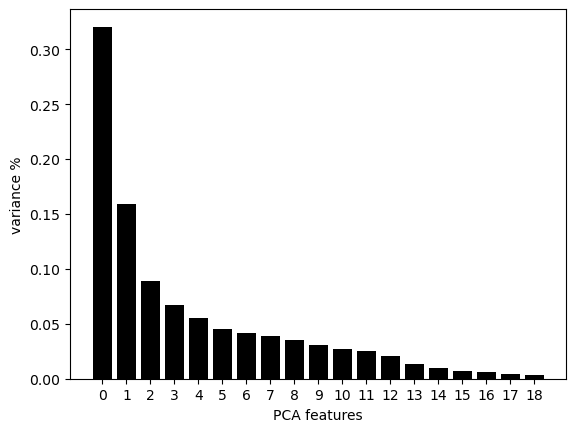

In [102]:
# Create a PCA Instance
pca = PCA()
pca.fit(x_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

The first three components seem to explain at least 55% of the data, which is sufficient for myself to stop at that amount of components. Three components is less intuitive than two, but two components would not accurately capture the data.

In [104]:
# Create a 3D PCA Instance
pca = PCA(n_components=3)

pca.fit(x_scaled)

PCA(n_components=3)

<a id='section4.3'></a>
### <a id='#section4.3'>4.3 K-means clustering</a>

#### Why K-means clustering?
K-means clustering is another unsupervised machine learning technique that clusters observations into subgroups that contain observations similar to each other. It relies on a set amount of clusters and initializes random centroids. It iterates until cluster assignments stop changing. Then, for each cluster the mean is calculated and each observation is assigned to the cluster whose mean is nearest using the Euclidean distance to the nth power (however many components involved).

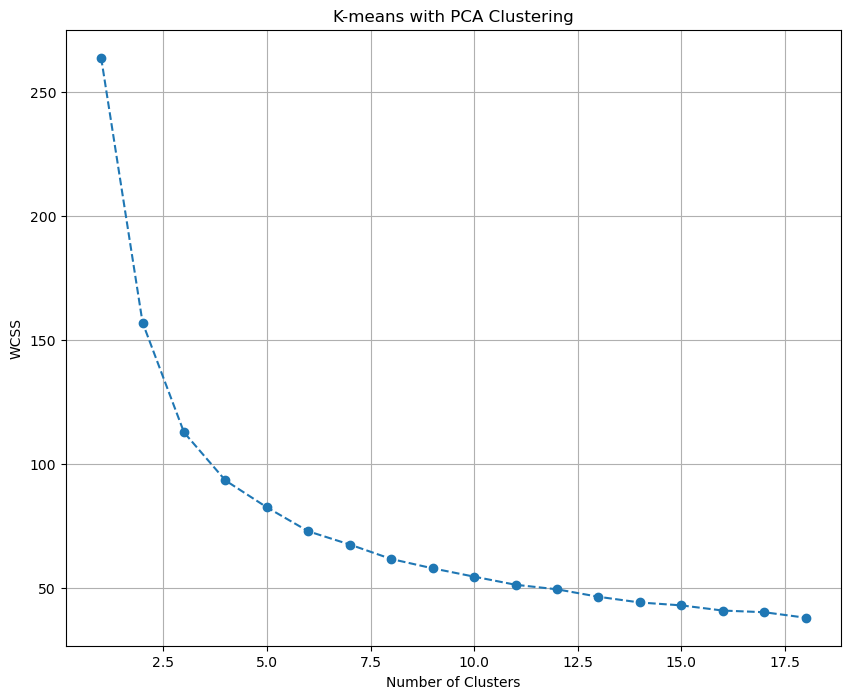

In [106]:
scores_pca = pca.transform(x_scaled)

# Optimum cluster amount selection
wcss = []
for k in range(1, 19):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 600, random_state = 42)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)

# Generate elbow plot
plt.figure(figsize=(10,8))
plt.plot(range(1, 19), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.grid(True)
plt.show()
    

Based on the scree plot, the optimal number of clusters is about 5 or 6. I ultimately decided on using 5 clusters.

In [108]:
# Doing K-means clustering
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [109]:
# Make new Data Frame with new components and clusters
df_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
df_kmeans.columns.values[-3:] = ['x', 'y', 'z']
df_kmeans['cluster'] = kmeans_pca.labels_

df_kmeans.head()

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90,x,y,z,cluster
0,Rúben Dias,Man City,Premier League,POR,D (C),-,Right,Set,NaN,27,4222,76.12,5.29,94,0.06,0.02,0.13,82,75,0.96,0.19,6.40,0.58,3.26,0.51,0.66,1.41,3.03,62,319.0,- - -,325000,2027-06-30,Not for Sale,46.911111,6.800095,1.321649,-0.071532,0.459090,0.119476,0
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32,4271,72.93,6.11,93,0.06,0.03,0.19,74,78,0.84,0.19,7.00,0.82,3.25,0.65,0.89,1.64,3.90,36,317.5,- - -,325000,2025-06-30,Not for Sale,47.455556,6.690471,0.758605,-0.128740,0.416993,0.221578,0
2,Aymeric Laporte,Man City,Premier League,ESP,D (C),Trained in nation (0-21),Left,Set,NaN,30,3248,73.46,5.29,94,0.05,0.03,0.17,85,72,1.08,0.28,6.01,0.67,2.91,0.64,1.05,1.63,3.88,16,246.6,- - -,325000,2026-06-30,Not for Sale,36.088889,6.833128,0.443350,-0.075039,0.404570,0.011798,0
3,Raphaël Varane,Man Utd,Premier League,FRA,D (C),Trained in nation (15-21),Right,Set,NaN,31,3528,62.60,4.92,92,0.05,0.03,0.13,74,78,1.02,0.36,8.09,0.97,2.60,0.84,1.35,1.94,3.93,20,270.3,- - -,350000,2026-06-30,Not for Sale,39.200000,6.895408,0.510204,-0.193609,0.169084,0.151468,0
4,Matthijs de Ligt,Bayern München,Bundesliga,NED,"D (C), DM",-,Right,NaN,NaN,24,2270,79.33,6.22,94,0.14,0.02,0.32,75,84,0.71,0.12,7.14,0.44,2.42,0.12,0.59,2.30,5.71,29,181.9,- - -,300000,2026-06-30,$86M - $108M,25.222222,7.211894,1.149780,0.116608,0.502355,0.479748,0


___
<a id='section5'></a>
## <a id='#section5'>5. Data Visualization</a>

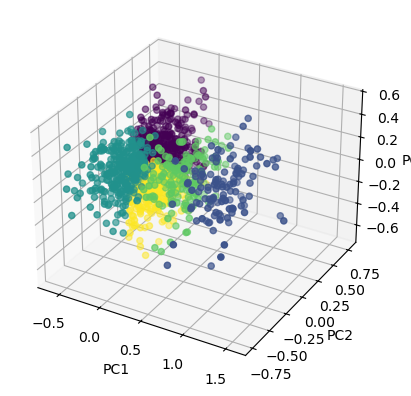

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_kmeans['x']
y = df_kmeans['y']
z = df_kmeans['z']

ax.set_facecolor('white')
ax.scatter3D(x,y,z, c=df_kmeans['cluster'], cmap='viridis')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [112]:
# Display the counts of the clusters
df_kmeans['cluster'].value_counts()

cluster
0    335
4    319
2    317
3    156
1    116
Name: count, dtype: int64

___
<a id='section6'></a>
## <a id='#section6'>6. Exploratory Data Analysis</a>

Want we will do is locate the coordinates of Virgil van Dijk, whom we are basing our profile for the modern "ball playing" centerback to be. We will then calculate each centerback's distance from Virgil van Dijk's point. 

<a id='section6.1'></a>
### <a id='#section6.1'>6.1 Locating Virgil van Dijk</a>

Virgil van Dijk's coordinates are to be found, and we will create a column of data that shows distance from van Dijk's point.

In [115]:
vvd_x = float(df_kmeans['x'][df_kmeans['Name'] == 'Virgil van Dijk'].iloc[0])
vvd_y = float(df_kmeans['y'][df_kmeans['Name'] == 'Virgil van Dijk'].iloc[0])
vvd_z = float(df_kmeans['z'][df_kmeans['Name'] == 'Virgil van Dijk'].iloc[0])

df_kmeans['Distance from van Dijk'] = np.sqrt((df_kmeans['x'] - vvd_x)**2 +
                                              (df_kmeans['y'] - vvd_y)**2 +
                                              (df_kmeans['z'] - vvd_z)**2)

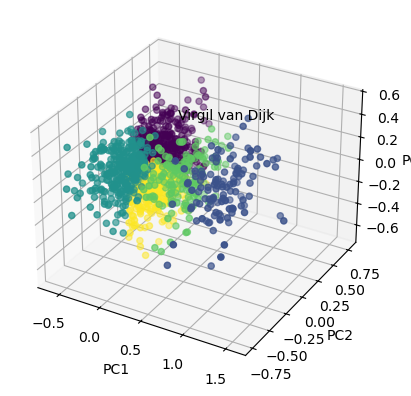

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_kmeans['x']
y = df_kmeans['y']
z = df_kmeans['z']

ax.set_facecolor('white')
ax.scatter3D(x,y,z, c=df_kmeans['cluster'], cmap='viridis')
ax.text(vvd_x, vvd_y, vvd_z, '%s' % (str('Virgil van Dijk')), color='k')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<a id='section6.2'></a>
### <a id='#section6.2'>6.2 Closest outputs to Virgil van Dijk</a>

The data is then filtered to consist of only players who share the same cluster as Virgil van Dijk, and we are sorting the players by their distance to him.

In [118]:
# Finding VVD's cluster number
vvd_cluster = int(df_kmeans['cluster'][df_kmeans['Name'] == 'Virgil van Dijk'].iloc[0])

# Sorting only players with the cluster of VVD
df_vvd = df_kmeans[df_kmeans['cluster'] == vvd_cluster]

# Sorting 
df_vvd = df_vvd.sort_values(by=['Distance from van Dijk'], ascending=True)

df_vvd.head(10)

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90,x,y,z,cluster,Distance from van Dijk
1,Virgil van Dijk,Liverpool,Premier League,NED,D (C),-,Right,Set,NaN,32,4271,72.93,6.11,93,0.06,0.03,0.19,74,78,0.84,0.19,7.00,0.82,3.25,0.65,0.89,1.64,3.90,36,317.5,- - -,325000,2025-06-30,Not for Sale,47.455556,6.690471,0.758605,-0.128740,0.416993,0.221578,0,0.000000
28,William Saliba,Arsenal,Premier League,FRA,D (RC),Trained in nation (15-21),Right,Set,NaN,23,4232,71.07,5.78,93,0.05,0.06,0.21,82,78,0.89,0.28,7.34,0.79,3.04,0.57,0.85,1.42,3.96,47,320.9,- - -,115000,2027-06-30,$216M - $270M,47.022222,6.824433,0.999527,-0.095430,0.372041,0.215516,0,0.056276
52,Josip Šutalo,Dinamo Zagreb,SuperSport Hrvatska nogometna liga,CRO,D (C),-,Right,Wnt,NaN,24,4587,69.61,5.75,93,0.08,0.08,0.14,77,77,0.86,0.24,7.99,0.67,3.10,0.53,1.04,1.51,3.55,28,343.9,- - -,7500,2027-06-15,$10M - $16.5M,50.966667,6.747547,0.549379,-0.109288,0.360329,0.226818,0,0.060139
108,Romain Saïss,Beşiktaş,Spor Toto Süper Lig,MAR,"D (C), DM",Trained in nation (15-21),Left,NaN,NaN,34,2942,74.67,5.84,93,0.06,0.04,0.24,63,72,0.76,0.15,6.73,0.83,3.70,0.28,0.73,1.50,3.85,32,221.5,- - -,30000,2024-06-30,$110K - $1.1M,32.688889,6.776003,0.978926,-0.080183,0.466616,0.204837,0,0.071418
21,Éder Militão,Real Madrid,LaLiga Santander,BRA,D (C),-,Right,NaN,NaN,26,4540,73.21,5.99,93,0.07,0.03,0.24,70,75,0.85,0.18,7.53,0.56,3.17,0.36,0.85,1.31,3.17,45,344.4,- - -,300000,2027-06-30,$109M - $167M,50.444444,6.827313,0.892070,-0.125551,0.460968,0.164427,0,0.072182
313,Jurgen Mattheij,CSKA-Sofia,efbet League,NED,D (C),-,Unknown,NaN,NaN,31,3537,76.13,5.80,90,0.07,0.05,0.10,76,83,0.89,0.23,9.06,0.51,2.75,0.84,1.02,1.40,3.94,21,261.9,- - -,2700,2025-06-30,Not for Sale,39.300000,6.664122,0.534351,-0.185931,0.348164,0.230949,0,0.089979
79,Tanguy Nianzou,Sevilla,LaLiga Santander,FRA,"D (C), DM, M (C)",Trained in nation (15-21),Right,NaN,NaN,21,3715,70.93,5.98,92,0.07,0.02,0.48,71,76,1.14,0.36,7.53,0.80,2.69,0.68,0.82,1.91,4.34,38,284.3,- - -,76000,2026-06-30,$38M - $47M,41.277778,6.887483,0.920592,-0.062877,0.356925,0.207126,0,0.090305
300,Pablo Insua,Sporting Gijón,LaLiga SmartBank,ESP,D (C),-,Right,NaN,NaN,30,2259,81.35,7.21,92,0.06,0.01,0.16,70,80,0.64,0.12,8.45,0.52,4.58,0.80,0.92,1.95,5.06,14,179.6,- - -,5750,2025-06-30,$190K - $1.9M,25.100000,7.155378,0.557769,-0.079330,0.496157,0.231052,0,0.093798
948,José Fonte,Lille,Ligue 1 Uber Eats,POR,D (C),-,Right,NaN,NaN,40,2940,68.66,6.03,93,0.04,0.02,0.03,75,84,0.83,0.12,8.39,0.77,3.46,0.64,0.58,1.74,3.98,19,221.0,- - -,22500,2024-06-30,$40K - $400K,32.666667,6.765306,0.581633,-0.164541,0.413288,0.309042,0,0.094580
119,Connor Goldson,Rangers,cinch Premiership,ENG,D (C),-,Right Only,NaN,NaN,31,4762,76.00,5.71,93,0.07,0.03,0.09,77,78,0.91,0.25,8.35,0.66,3.82,0.68,1.12,1.59,3.42,30,356.2,- - -,40500,2025-05-31,Not for Sale,52.911111,6.732045,0.566989,-0.212609,0.383423,0.158523,0,0.110167


This is a good sign, since William Saliba is one of the best defenders in the world and is one of the centerbacks most similar to Virgil van Dijk. We can also see that Real Madrid's Éder Militão is in this list, who is valued at over 100 million. 

<a id='section6.3'></a>
### <a id='#section6.3'>6.3 Filtering for a desired profile</a>

#### What type of player do we want to sign for FC Girondins de Bordeaux?

Ideally, we would like a player who:
* Earns a salary less than $15,000 per week
* **Cannot** be older than 28
* Their contract expires on or before June 30th, 2024, so that they could be bought for a cut price

We have a transfer budget of \\$5,000,000 so they must be acquriable for this price or less. We will look at players whose ranges are completely within this \\$5 million budget.

In [121]:
df_vvd_filtered = df_vvd[
    (df_vvd['Salary'] <= 15000) &
    (df_vvd['Age'] <= 28.0) &
    (df_vvd['Expires'] <= '2024-06-30')
]

df_vvd_filtered.shape
#df_vvd_filtered.to_excel('BPD.xlsx', index=False)

(21, 42)

Our filters have resulted in a dataframe of 21 available centerbacks, much less than the initial 20,000 players.

In [123]:
df_vvd_filtered

,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90,x,y,z,cluster,Distance from van Dijk
261,Olivier Verdon,Ludogorets Razgrad,efbet League,BEN,"D (C), DM",Trained in nation (15-21),Right Only,NaN,NaN,28,3335,71.35,5.67,90,0.07,0.03,0.11,84,80,1.03,0.22,7.80,0.38,3.10,0.49,1.05,1.46,3.54,22,246.6,- - -,5750,2024-06-30,$300K - $3.1M,37.055556,6.654873,0.593703,-0.147120,0.350316,0.116965,0,0.125409
379,Valeriy Bondar,Shakhtar,FavBet Liha,UKR,D (C),-,Unknown,Wnt,NaN,25,2764,66.07,5.96,88,0.04,0.02,0.16,58,72,0.46,0.13,6.81,0.75,3.32,0.49,0.78,1.30,2.93,28,202.1,- - -,8000,2023-10-31,Unknown,30.711111,6.580680,0.911722,-0.205484,0.383151,0.085985,0,0.159438
374,Noah Sonko Sundberg,Levski Sofia,efbet League,GAM,D (C),-,Unknown,Wnt,NaN,27,3460,82.98,8.64,92,0.08,0.03,0.08,76,74,0.91,0.16,7.36,0.47,3.10,0.68,1.20,1.64,3.51,37,252.2,- - -,1800,2023-06-30,Unknown,38.444444,6.560116,0.962428,-0.059004,0.575797,0.194778,0,0.175499
1039,Stratos Svarnas,Raków Częstochowa,PKO Ekstraklasa,GRE,D (RC),-,Right,NaN,NaN,26,2924,74.24,5.88,89,0.08,0.02,0.18,81,76,0.92,0.18,8.06,0.52,3.79,0.58,1.48,1.82,4.28,21,230.0,- - -,2800,2024-06-30,$220K - $2.2M,32.488889,7.079343,0.646375,-0.101953,0.270298,0.128614,0,0.175725
301,Kristian Dimitrov,Levski Sofia,efbet League,BUL,D (C),-,Unknown,NaN,NaN,27,2248,83.35,5.12,89,0.04,0.03,0.16,72,85,0.92,0.12,9.13,0.88,2.36,0.52,1.32,1.56,3.24,15,165.0,- - -,1500,2023-06-30,Unknown,24.977778,6.605872,0.600534,-0.282841,0.292975,0.331042,0,0.226075
477,Asger Sørensen,Sparta Prague,Fortuna liga,DEN,D (C),-,Unknown,NaN,NaN,27,2287,58.32,5.00,88,0.08,0.05,0.16,72,71,0.71,0.31,7.83,0.35,4.21,0.51,0.71,1.06,3.74,6,171.4,- - -,4200,2024-06-30,Unknown,25.411111,6.745081,0.236117,-0.194395,0.307865,-0.054149,0,0.303718
1212,Abdoulaye Ndiaye,Bastia,Ligue 2 BKT,SEN,D (C),-,Left Only,NaN,NaN,22,3026,56.51,5.18,87,0.02,0.02,0.00,68,78,0.77,0.27,10.23,0.86,3.06,0.80,0.95,2.11,4.31,27,224.8,- - -,3400,2024-06-30,$20K - $200K,33.622222,6.686054,0.803040,-0.221917,0.111556,0.194045,0,0.320518
610,Loïc Mbe Soh,Guingamp,Ligue 2 BKT,CMR,D (C),Trained in nation (15-21),Right,Inj,NaN,22,3295,69.62,5.95,85,0.05,0.02,0.22,81,81,1.07,0.19,9.92,0.93,4.34,0.76,1.61,1.88,5.08,14,273.9,- - -,4600,2023-06-30,$7.2M - $9.2M,36.611111,7.481335,0.382398,-0.182527,0.083827,0.276931,0,0.341990
888,Denis Haruţ,FCSB,SuperLiga,ROU,D (RC),-,Unknown,NaN,NaN,25,2276,73.91,5.73,89,0.03,0.03,0.20,82,65,0.71,0.16,5.93,0.51,3.48,0.79,0.99,1.34,4.47,14,172.1,- - -,2800,2024-06-30,Unknown,25.288889,6.805360,0.553603,-0.047854,0.402311,-0.116346,0,0.347780
803,Mihajlo Ivančević,OB,3F Superliga,SRB,"D (C), DM",-,Right,NaN,NaN,25,2789,57.15,4.45,88,0.07,0.08,0.13,74,75,0.74,0.16,8.04,0.58,4.03,0.84,1.19,1.71,4.32,20,215.6,- - -,4000,2024-06-30,$180K - $1.8M,30.988889,6.957332,0.645393,-0.041891,0.096831,0.106785,0,0.351033


<a id='section6.4'></a>
### <a id='#section6.4'>6.4 Closest Performing Players with an Expiring Contract</a>

In [125]:
# Filtering Data Frame to only include players whose contracts are expiring on or before June 30th, 2023
df_vvd_filtered_exp = df_vvd_filtered[df_vvd_filtered['Expires'] <= '2023-06-30']

# Show results
print(df_vvd_filtered_exp.shape)
df_vvd_filtered_exp

(6, 42)


,Name,Club,Division,Nat,Position,Home Grown Status,Preferred Foot,Inf,WR,Age,Mins,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Fls,Distance,Rec,Salary,Expires,Transfer Value,90s,Distance/90,Fls/90,x,y,z,cluster,Distance from van Dijk
374,Noah Sonko Sundberg,Levski Sofia,efbet League,GAM,D (C),-,Unknown,Wnt,NaN,27,3460,82.98,8.64,92,0.08,0.03,0.08,76,74,0.91,0.16,7.36,0.47,3.10,0.68,1.20,1.64,3.51,37,252.2,- - -,1800,2023-06-30,Unknown,38.444444,6.560116,0.962428,-0.059004,0.575797,0.194778,0,0.175499
301,Kristian Dimitrov,Levski Sofia,efbet League,BUL,D (C),-,Unknown,NaN,NaN,27,2248,83.35,5.12,89,0.04,0.03,0.16,72,85,0.92,0.12,9.13,0.88,2.36,0.52,1.32,1.56,3.24,15,165.0,- - -,1500,2023-06-30,Unknown,24.977778,6.605872,0.600534,-0.282841,0.292975,0.331042,0,0.226075
610,Loïc Mbe Soh,Guingamp,Ligue 2 BKT,CMR,D (C),Trained in nation (15-21),Right,Inj,NaN,22,3295,69.62,5.95,85,0.05,0.02,0.22,81,81,1.07,0.19,9.92,0.93,4.34,0.76,1.61,1.88,5.08,14,273.9,- - -,4600,2023-06-30,$7.2M - $9.2M,36.611111,7.481335,0.382398,-0.182527,0.083827,0.276931,0,0.341990
1078,Alfie Jones,Hull City,Sky Bet Championship,ENG,"D (C), DM",-,Right,Wnt,NaN,26,2803,58.69,4.69,87,0.04,0.03,0.16,67,77,0.58,0.32,8.16,0.93,3.56,0.67,1.25,1.93,4.62,15,211.2,- - -,6750,2023-06-30,$0 - $24K,31.144444,6.781306,0.481627,-0.240748,0.105439,0.102456,0,0.351854
504,Ryan Flamingo,Vitesse,Eredivisie,NED,"D (C), DM",-,Right,Trn,NaN,21,3175,61.31,3.51,86,0.02,0.06,0.06,82,76,1.02,0.26,7.17,0.62,2.75,0.60,0.85,1.39,4.05,27,238.9,- - -,5250,2023-06-30,$0 - $110K,35.277778,6.771969,0.765354,-0.092058,0.120763,0.016978,0,0.361883
889,Cédric Kipré,Cardiff,Sky Bet Championship,CIV,D (C),Trained in nation (15-21),Right,Wnt,NaN,27,3405,61.93,4.65,88,0.06,0.04,0.16,74,71,0.85,0.40,7.43,0.66,3.78,0.71,1.22,1.67,3.73,27,251.9,- - -,13750,2023-06-30,$50K - $500K,37.833333,6.658150,0.713656,-0.184253,0.167867,-0.052681,0,0.374651


This filtration leaves us with six players who we do not need to pay a transfer fee for. However Ryan Flamingo who, on the eye, looks like the best possible option (U21 and played in the 7th-best European league!) has the symbol `Trn` under `Inf` which means that he has a transfer arranged. He had already agreed a pre-contract with another club so he will not be able to be signed.

This leaves us with five players, and we will compare their output with Virgil van Dijk's output.

In [127]:
# Drop Ryan Flamingo
df_vvd_filtered_exp = df_vvd_filtered_exp[df_vvd_filtered_exp['Name'] != 'Ryan Flamingo']

---

<a id='section7'></a>

## <a id='#section7'>7. Shortlist Deep-Dive</a>

<a id='section7.1'></a>
### <a id='#section7.1'>7.1 Assigning percentiles to output</a>

For each player in the shortlist, we percentile rank each of the metrics against defenders in the entire dataset.

In [130]:
import pandas as pd
from scipy.stats import percentileofscore

# Players of interest
players = df_vvd_filtered_exp['Name'].tolist()
players.insert(0, 'Virgil van Dijk')

df_percentiles = df[df['Name'].isin(players)]

for column in df_percentiles:  
    if (column in selected_stats or column == 'Name' or column == 'Club'):
        pass
    else:
        df_percentiles.drop(column, axis=1, inplace=True)

# Getting percentiles
for player in players:
    for stat in selected_stats:
        p = round(
            percentileofscore(df[stat], df[stat][df['Name'] == player].iloc[0]), 0
        )
        row_index = df_percentiles[df_percentiles['Name'] == player].index[0]
        df_percentiles.at[row_index, stat] = p

df_percentiles = df_percentiles.reset_index(drop=True)
df_percentiles.head()

,Name,Club,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Distance/90,Fls/90
0,Virgil van Dijk,Liverpool,91.0,94.0,97,82.0,45.0,58.0,29,71,23.0,33.0,44.0,81.0,52.0,42.0,7.0,35.0,28.0,24.0,47.0
1,Kristian Dimitrov,Levski Sofia,99.0,79.0,74,57.0,45.0,50.0,20,96,35.0,11.0,87.0,86.0,6.0,14.0,40.0,28.0,5.0,13.0,22.0
2,Noah Sonko Sundberg,Levski Sofia,99.0,100.0,93,93.0,45.0,23.0,38,50,33.0,23.0,53.0,33.0,42.0,49.0,29.0,35.0,12.0,9.0,71.0
3,Loïc Mbe Soh,Guingamp,87.0,92.0,39,72.0,24.0,65.0,64,84,60.0,33.0,94.0,89.0,98.0,66.0,69.0,59.0,71.0,90.0,4.0
4,Cédric Kipré,Cardiff,71.0,64.0,66,82.0,62.0,50.0,29,33,24.0,94.0,55.0,63.0,84.0,55.0,31.0,38.0,20.0,20.0,41.0


<a id='section7.2'></a>
### <a id='#section7.2'>7.2 Data Visualizations: Pizza Radar</a>

Using "pizza plots" with instructions from [mplsoccer](https://mplsoccer.readthedocs.io/en/latest/), we will find a way to visualize the percentiles across all metrics of interest, and compare with Virgil van Dijk's radar.

In [132]:
# Creating random RGB color method for data viz purposes
import random

def get_random_rgb():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return r, g, b

I adjusted the pizza radar method in mplsoccer to generate pizza plots whenever we input a dataframe of percentiles, a list of metrics, along with a player name and their club.

In [134]:
def pizza_radar(df, params, name, club):
    # instantiate PyPizza class
    baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
    )
    # plot pizza

    r, g, b = get_random_rgb()

    fig, ax = baker.make_pizza(
        df[params][df['Name'] == name].values.tolist()[0],              # list of values
        figsize=(8, 8),      # adjust figsize according to your need
        param_location=110,  # where the parameters will be added
        kwargs_slices=dict(
            facecolor=(r, g, b, 1), edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor=(r, g, b, .5),
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    # add title
    fig.text(
        0.515, 0.97, f"{name} – {club}", size=18,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Centerbacks | Season 2022-23",
        size=15,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add credits
    CREDIT_1 = "data: football manager 2023"
    CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"
    
    fig.text(
        0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9,
        fontproperties=font_italic.prop, color="#000000",
        ha="right"
    )
    plt.savefig(f"{name}-{club}-pizza_radar.png")
    plt.show()

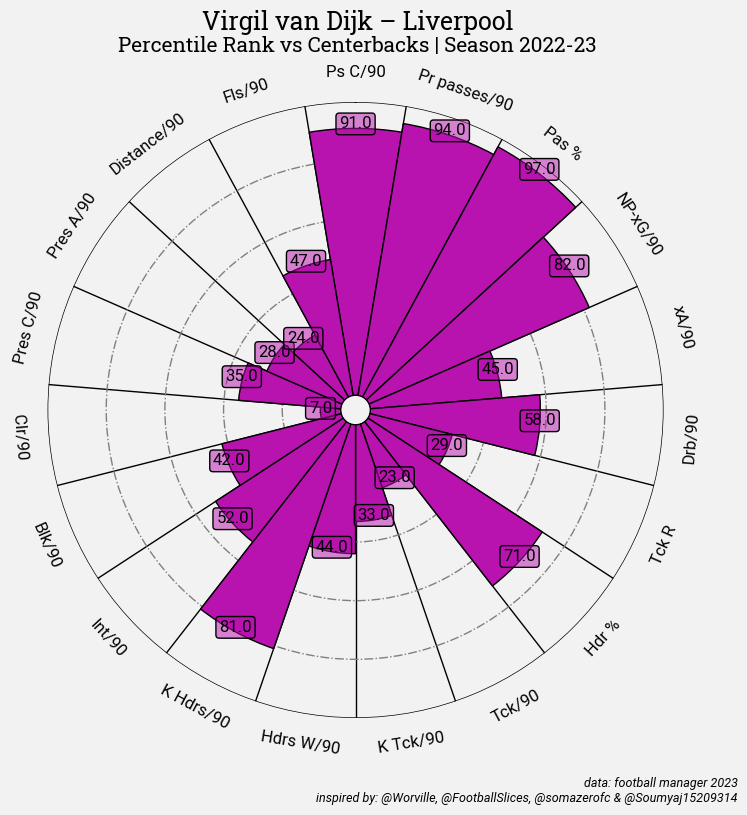

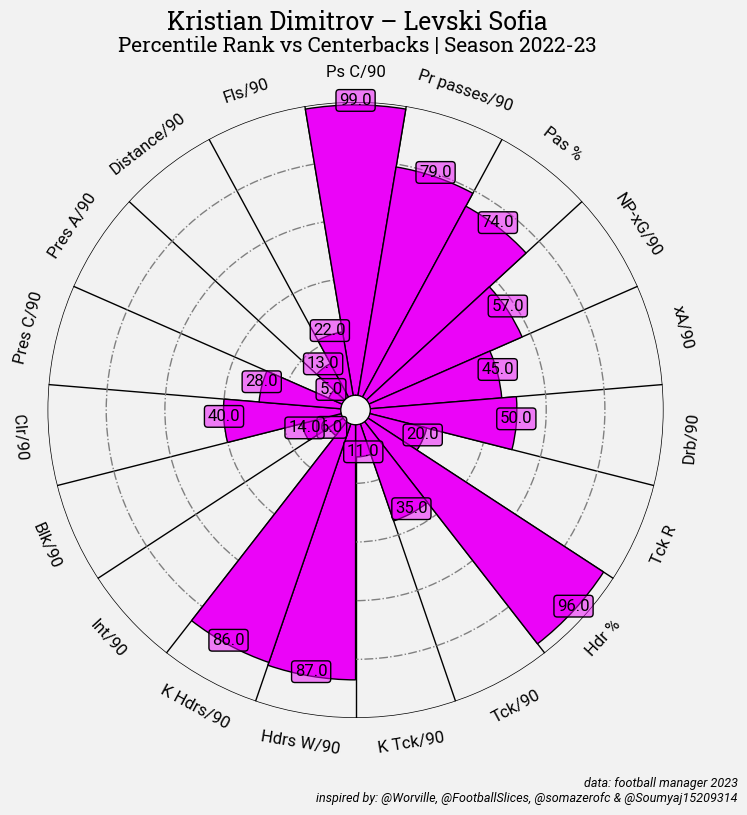

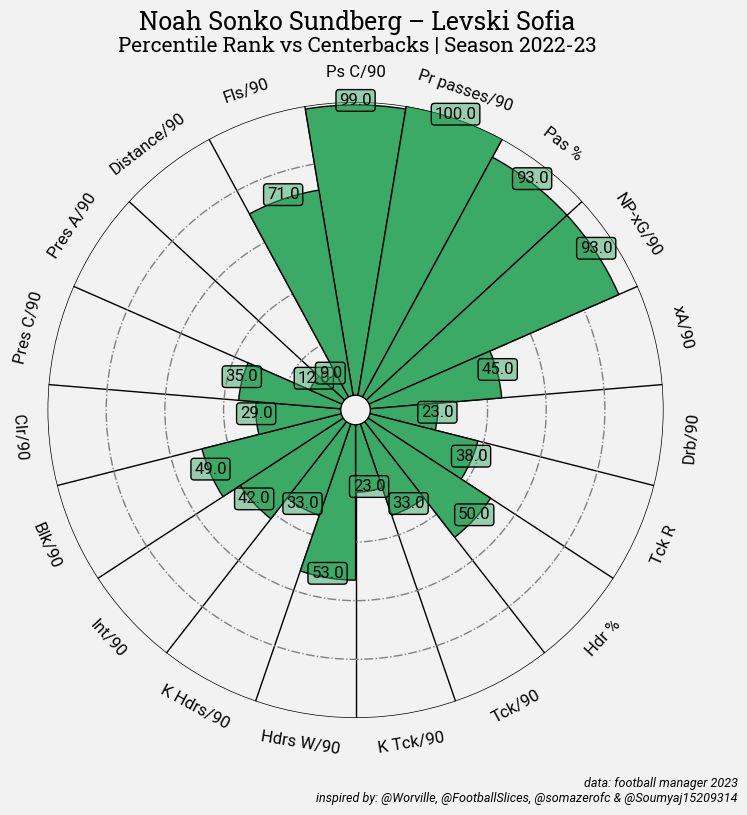

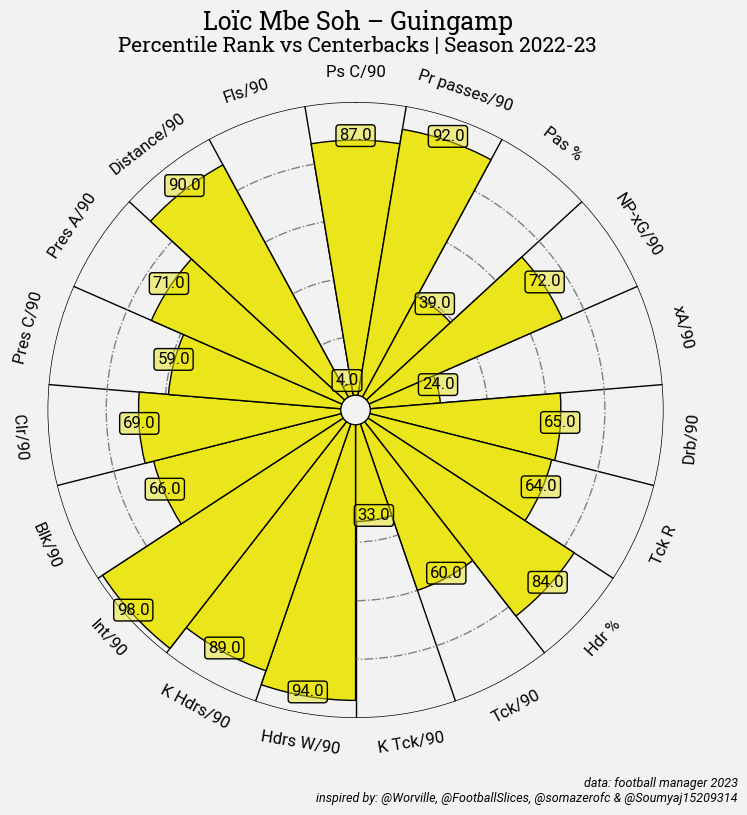

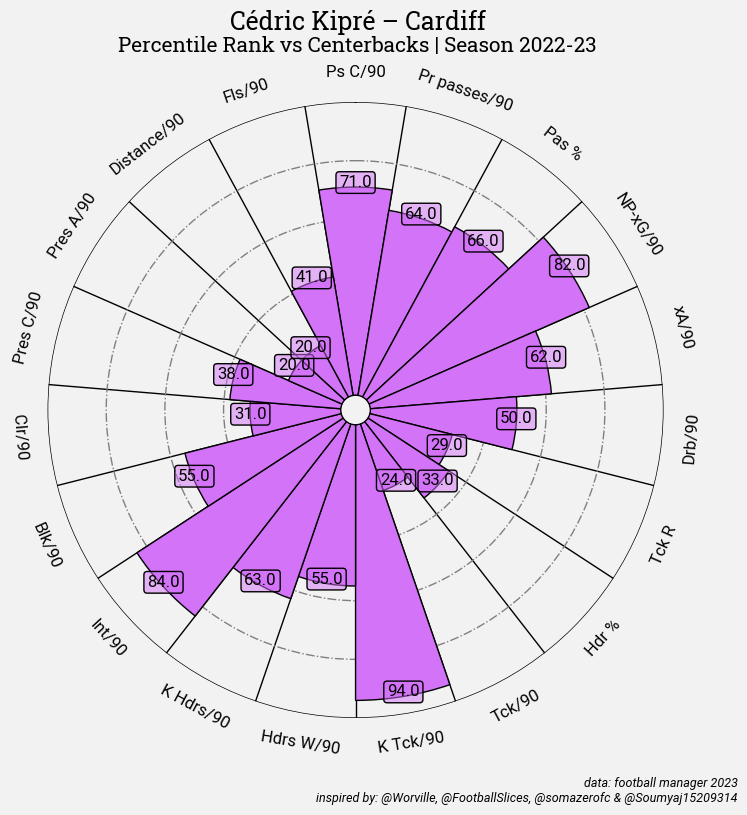

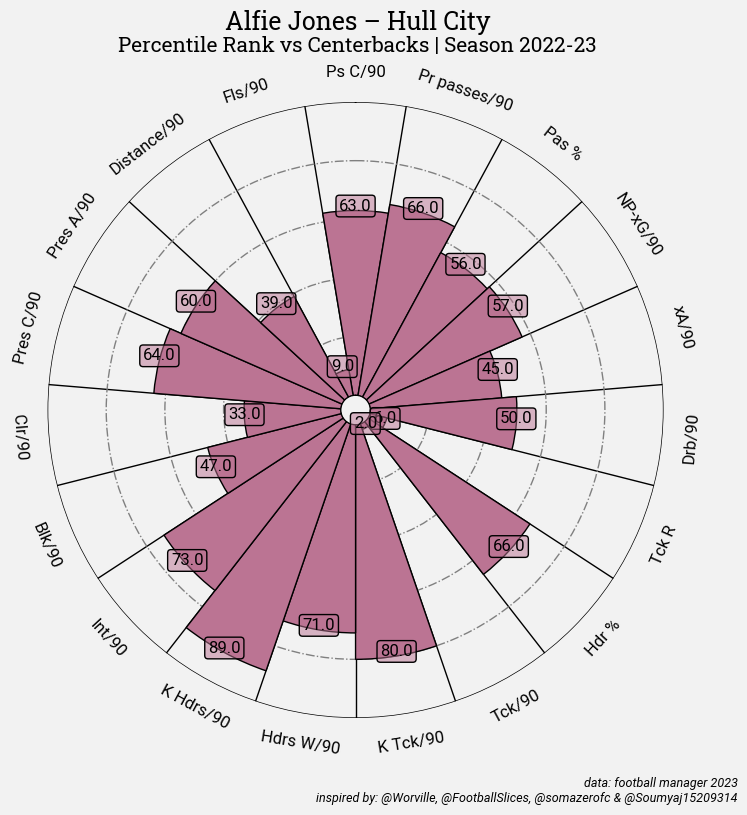

In [135]:
# This method creates pizza plots for each player in the shortlist

for player in df_percentiles['Name']:
    club = df_percentiles[df_percentiles['Name'] == player]['Club'].tolist()[0]
    pizza_radar(df_percentiles, selected_stats, player, club)

In [136]:
def comp_pizza_radar(df, params, name):    
    # instantiate PyPizza clas
    baker = PyPizza(
        params=params,                  # list of parameters
        background_color="#EBEBE9",     # background color
        straight_line_color="#222222",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        last_circle_color="#222222",
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )

    fig, ax = baker.make_pizza(
        df[params][df['Name'] == 'Virgil van Dijk'].values.tolist()[0], # van Dijk values
        compare_values=df[params][df['Name'] == name].values.tolist()[0], # list of comparison values
        figsize=(8, 8),      # adjust figsize according to your need
        kwargs_slices=dict(
            facecolor="#1A78CF", edgecolor="#222222",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        
        kwargs_compare=dict(
            facecolor="#FF9300", edgecolor="#222222",
            zorder=2, linewidth=1,
        ),
        
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        ),                  # values to be used when adding parameter-values
        kwargs_compare_values=dict(
            color="#000000", fontsize=12, fontproperties=font_normal.prop, zorder=3,
            bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
        ),                  # values to be used when adding parameter-values labels
    )

    # add title
    fig_text(
        0.515, 0.99, f"<{name}> vs <Virgil van Dijk>", size=17, fig=fig,
        highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Centerbacks | Season 2022-23",
        size=15,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add credits
    CREDIT_1 = "data: football manager 2023"
    CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"
    
    fig.text(
        0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9,
        fontproperties=font_italic.prop, color="#000000",
        ha="right"
    )
    plt.savefig(f"{name}-vs-VVD_pizza_radar.png")
    plt.show()

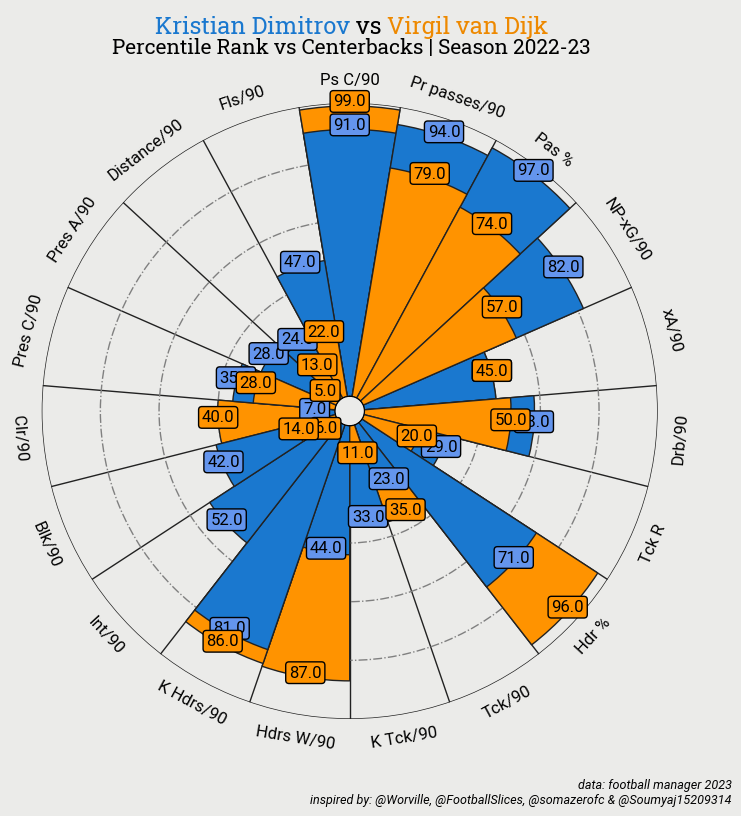

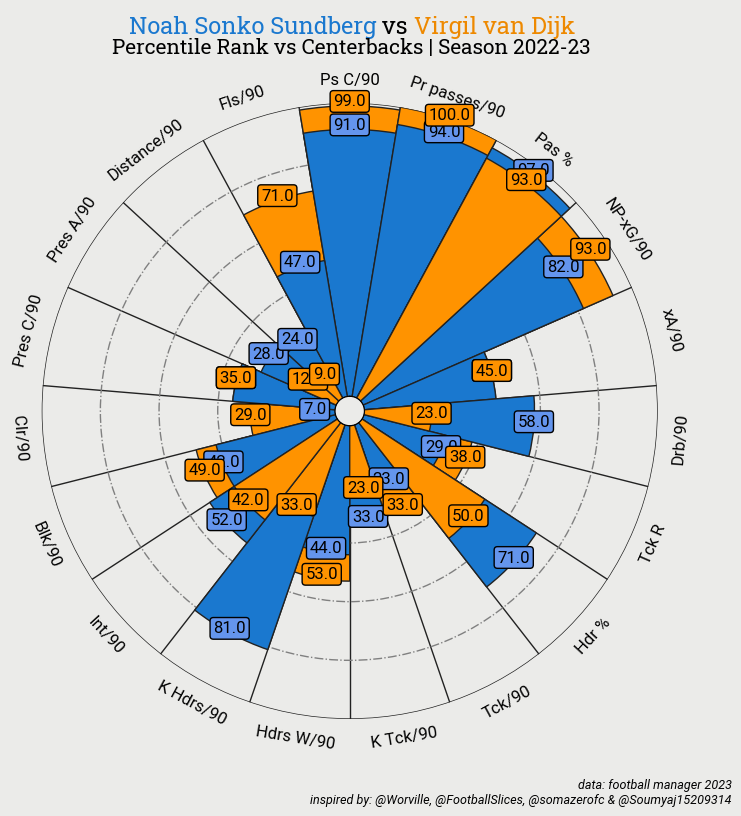

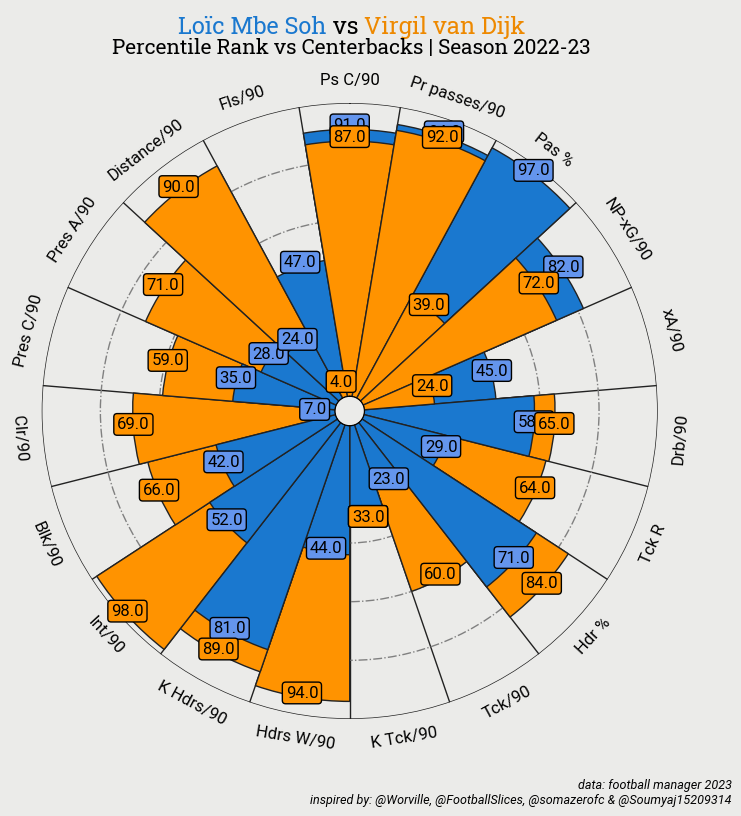

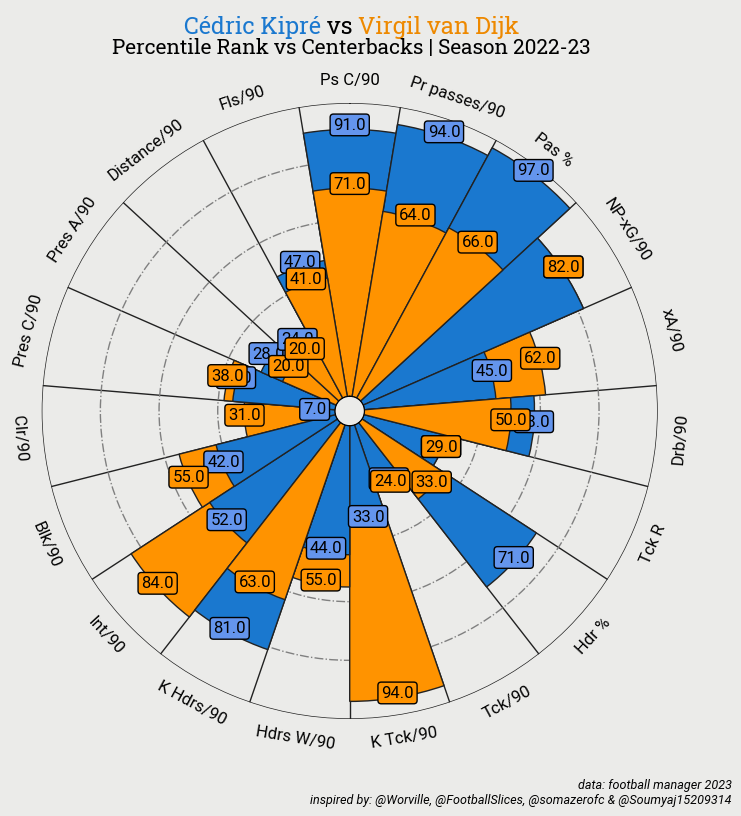

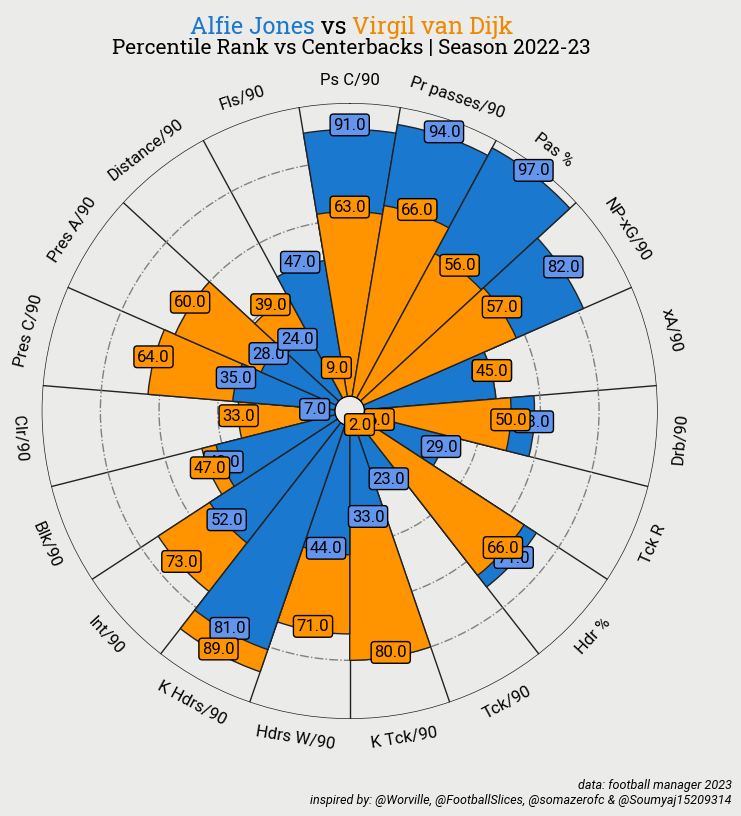

In [137]:
# This method creates comparison pizza plots for each player in the shortlist

for player in df_percentiles['Name']:
    if (player != 'Virgil van Dijk'):
        comp_pizza_radar(df_percentiles, selected_stats, player)

<a id='section7.3'></a>
### <a id='#section7.3'>7.3 Using Mean Squared Errors to assess candidates</a>

On the eye, we can identify some pizza charts that are way off from Virgil van Dijk's statistics but we would like to find a way to calculate this as a number using a metric called the Mean Squared Errors, or MSE, using van Dijk's percentiles as the baseline, or technically the "mean". The MSE assesses the quality of any of the players' percentile values in comparison to Virgil van Dijk, with the errors being squared so that the further a player's percentiles are away from van Dijk's the harsher they will get punished. The "best" or most similar fit to Virgil van Dijk will be the player with the lowest MSE. 

In [139]:
# Initializing MSE list to append values to
mse = []

# Looping through dataframe and calculating SSE (sum of squared errors)
# so we can find MSE after
for player in range(len(df_percentiles['Name'])):
    sse = 0
    for col in selected_stats:
        sse = sse + (df_percentiles[col][df_percentiles['Name'] == 'Virgil van Dijk'] -
                    df_percentiles[col][player])**2
        if (col == selected_stats[len(selected_stats)-1]):
            mse.append(float((sse/len(selected_stats)).iloc[0]))
            break

# Putting our MSE list into the dataframe
df_percentiles['MSE'] = mse

# Sorting entire data frame on MSE
df_percentiles = df_percentiles.sort_values(by='MSE').reset_index(drop=True)
df_percentiles

,Name,Club,Ps C/90,Pr passes/90,Pas %,NP-xG/90,xA/90,Drb/90,Tck R,Hdr %,Tck/90,K Tck/90,Hdrs W/90,K Hdrs/90,Int/90,Blk/90,Clr/90,Pres C/90,Pres A/90,Distance/90,Fls/90,MSE
0,Virgil van Dijk,Liverpool,91.0,94.0,97,82.0,45.0,58.0,29,71,23.0,33.0,44.0,81.0,52.0,42.0,7.0,35.0,28.0,24.0,47.0,0.000000
1,Noah Sonko Sundberg,Levski Sofia,99.0,100.0,93,93.0,45.0,23.0,38,50,33.0,23.0,53.0,33.0,42.0,49.0,29.0,35.0,12.0,9.0,71.0,302.473684
2,Cédric Kipré,Cardiff,71.0,64.0,66,82.0,62.0,50.0,29,33,24.0,94.0,55.0,63.0,84.0,55.0,31.0,38.0,20.0,20.0,41.0,397.842105
3,Kristian Dimitrov,Levski Sofia,99.0,79.0,74,57.0,45.0,50.0,20,96,35.0,11.0,87.0,86.0,6.0,14.0,40.0,28.0,5.0,13.0,22.0,473.894737
4,Alfie Jones,Hull City,63.0,66.0,56,57.0,45.0,50.0,6,66,2.0,80.0,71.0,89.0,73.0,47.0,33.0,64.0,60.0,39.0,9.0,542.473684
5,Loïc Mbe Soh,Guingamp,87.0,92.0,39,72.0,24.0,65.0,64,84,60.0,33.0,94.0,89.0,98.0,66.0,69.0,59.0,71.0,90.0,4.0,1031.736842


Analysis: 

This resulting dataframe shows that Gambian centerback Noah Sonko Sundberg of Levski Sofia has performed closest to Virgil van Dijk, albeit in the Bulgarian League. Seeing that he is a centerback who we would not have to pay a fee for and that he had put up these numbers in a European top division, he is someone worth taking a risk on. He is a perfect match for playing the role of ball-playing centerback as he had been in the 99th and 100th percentiles for passes completed per 90 and progressiver passes per 90, along with a pass completion rate in the 93rd percentile. 

Therefore, Sonko Sundberg is my recommended Bordeaux centerback signing and I will look to snap him up on a free transfer come June 30th, 2023 in the game. 

---

<a id='section8'></a>

## <a id='#section8'>8. Conclusion</a>

In this notebook I had cleaned and analyzed a dataset from Football Manager containing performance statistics for the purpose of recruiting a centerback to start for a newly-promoted team in Ligue 1. `NumPy` was used for a select few mathematical functions, while most of the computations and data analysis involved usage of `pandas`. In addition, Principal Component Analysis and K-means clustering called on machine learning library `sklearn`. To top it off I had used various libraries for data visualizations, such as `matplotlib` and `seaborn` for standard data viz, and `mplsoccer` for the pizza radars. 

All of this analysis resulted in a shortlist of 5 potential players to sign:
1. Noah Sonko Sunberg of Levski Sofia and Gambia
2. Cédric Kipré of Cardiff City and Ivory Coast
3. Kristian Dimitrov of Levski Sofia and Bulgaria
4. Alfie Jones of Hull City and England
5. Loïc Mbe Soh of Guingamp and France

---

<a id='section9'></a>

## <a id='#section9'>9. Next Steps</a>

My next steps for this specific analysis would be to:
* Apply this analysis to all other positions by creating function-heavy and replicable code so that all I need to input is data and a player to "replicate" and I will receive it in an instant
* Use real-world data to achieve a similar outcome. This would involve more data cleaning and would improve my familiarity with python as a whole
* Create more soccer-specific visualizations